# Tweet Generation by fine tuning gpt-2

### Author - Devendra Kayande

## Installing and loading dependencies

In [1]:
!pip install transformers # installing hugging face library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.6 MB/s eta 0:00:00


In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.6 MB/s eta 0:00:00


In [3]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 20.0 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random
import transformers
import re
import string
import gensim
from string import punctuation
from wordcloud import WordCloud
import os, sys, re, uuid, time, warnings,sklearn,nltk, logging, functools, time
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from collections import Counter

from transformers import GPT2Tokenizer
from datasets import Dataset
from transformers import AutoTokenizer, GPT2LMHeadModel
from transformers.optimization import Adafactor 
from transformers.optimization import get_scheduler
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import list_metrics
from datasets import load_metric

In [5]:
transformers.__version__

'4.29.1'

## Loading  tweets 

I already downloaded sentiment analysis data from Kaggle and uploaded to my GDrive and loading the data from Drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Twitter_Sentiment_Analysis.zip

Archive:  /content/drive/MyDrive/Twitter_Sentiment_Analysis.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
csv_file='/content/training.1600000.processed.noemoticon.csv'
columns = ['target','ids','date','flag','user','text']
df=pd.read_csv(csv_file,names=columns,encoding='ISO-8859-1')
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
tweets=df[['text']].astype(str)
tweets

,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."
...,...
1599995,Just woke up. Having no school is the best fee...
1599996,TheWDB.com - Very cool to hear old Walt interv...
1599997,Are you ready for your MoJo Makeover? Ask me f...
1599998,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
tweets.isnull().sum()

text    0
dtype: int64

In [ ]:
df_1=tweets.iloc[:40000]
df_1.to_csv('/content/drive/MyDrive/chunk_1.csv')

In [ ]:
df_2=tweets.iloc[40000:80000]
df_2.to_csv('/content/drive/MyDrive/chunk_2.csv')

In [ ]:
df_3=tweets.iloc[80000:120000]
df_3.to_csv('/content/drive/MyDrive/chunk_3.csv')

In [ ]:
df_4=tweets.iloc[120000:160000]
df_4.to_csv('/content/drive/MyDrive/chunk_4.csv')

In [ ]:
tweets_list=list(df.text)

## Text Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Making a stopword list

In [ ]:
stopwordlist = set(stopwords.words('english'))- {'not', 'no', 'never'}
stopwordlist

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'nor',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 're',
 's',
 'sam

Making a function for preprocessing which includes removing stopwords,urls,tags,alphanumerics and stemming

In [ ]:
def preprocess(textdata):
    processedText =[]



    # Defining regex patterns.
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]\s"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with nothing
        tweet = re.sub(urlPattern, "", tweet,flags=re.MULTILINE)
        # Replace @USERNAME to nothing.
        tweet = re.sub(userPattern, "", tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, "", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # Remove punctuation
        tweet = tweet.translate(str.maketrans("","",string.punctuation))
            
            
        # Remove Stopwords
        tweetTokens = word_tokenize(tweet)
        filteredWords = [word for word in tweetTokens if word not in stopwordlist]
        
        # stemming 
        ps = PorterStemmer()
        stemmedWords = [ps.stem(word) for word in filteredWords]
        
        # Create Lemmatizer.
        wordLemm = WordNetLemmatizer()   
        lemmaWords = [wordLemm.lemmatize(word,pos='a') for word in stemmedWords]
        
        # Joining the words of a tweet 
        cleanTweet = " ".join(lemmaWords)
        
        # Adding the tweet to the processedText array
        processedText.append(cleanTweet)

        # Converting again to dataframe
        df=pd.DataFrame(processedText,columns=['preprocessed_text'])

    return processedText,df 

In [ ]:
tweets_preprocessed_list,tweets_preprocessed_df = preprocess(tweets_list)      

Loading our all chunks of data

In [7]:
pdf_1=pd.read_csv('/content/drive/MyDrive/pchunk_1.csv')
pdf_2=pd.read_csv('/content/drive/MyDrive/pchunk_2.csv')
pdf_3=pd.read_csv('/content/drive/MyDrive/pchunk_3.csv')
pdf_4=pd.read_csv('/content/drive/MyDrive/pchunk_4.csv')

tweets_preprocessed_df=pd.concat([pdf_1,pdf_2,pdf_3,pdf_4])

In [8]:
tweets_preprocessed_df.isnull().sum()

Unnamed: 0             0
preprocessed_text    565
dtype: int64

In [9]:
tweets_preprocessed_df.dropna(inplace=True)

In [10]:
tweets_preprocessed_df=tweets_preprocessed_df[['preprocessed_text']].astype(str)

In [11]:
tweets_preprocessed_df

,preprocessed_text
0,awwthat bummer shoulda got david carr third da...
1,upset cant updat facebook text itand might cri...
2,dive mani time ballmanag save 50 rest go bound
3,whole bodi feel itchi like fire
4,noit not behav allim madwhi herebecaus cant see
...,...
39995,home boredthink life
39996,wish could tell stop tweet caus im bloodi jeal...
39997,london moit ridicul hot left short homei dont ...
39998,one day san jose offici vacationif didnt get s...


Saving our preprocessed csv file 

In [27]:
tweets_preprocessed_df.to_csv('/content/drive/MyDrive/tweets.csv')
tweets_preprocessed_df.to_csv('/content/drive/MyDrive/tweets_no_headers.csv',header=False, index=False)

Checking distribution of lengths of tweets

7.14065


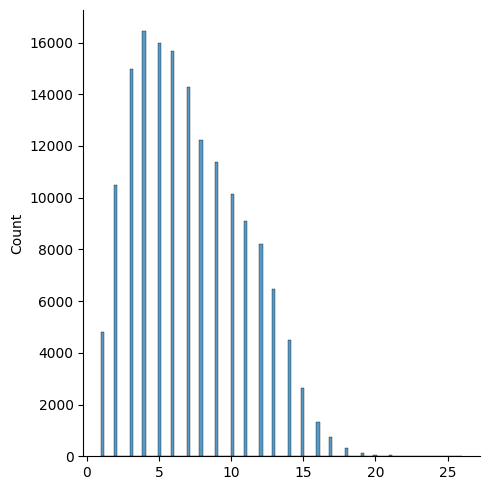

In [ ]:
doc_lengths = []

for elem in tweets_preprocessed_df['preprocessed_text']:
    # get rough token count distribution 
    tokens = nltk.word_tokenize(elem)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
sns.displot(doc_lengths)
print(np.average(doc_lengths))

Just for visualizing most frequent words in the corpus

(-0.5, 1599.5, 799.5, -0.5)

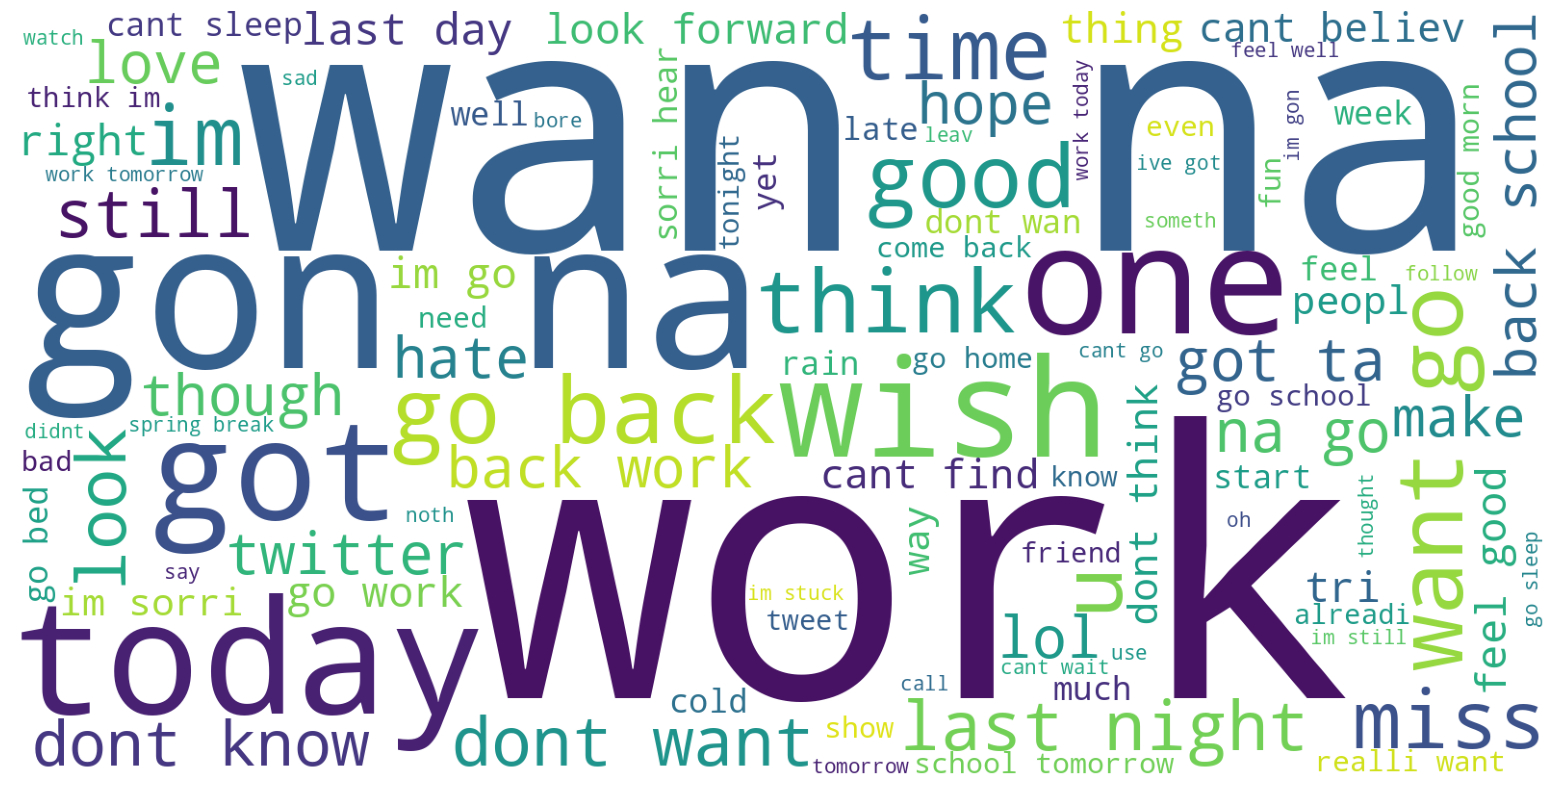

In [ ]:
#generate a word cloud image of tweets
text = " ".join(tweet for tweet in tweets_preprocessed_df['preprocessed_text'])
wordcloud = WordCloud(width = 1600, height = 800, max_words=100, background_color="white").generate(text)

#display the generated image
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")

<pre> <i>We will be using GPT-2 and fine tuning it using our tweet data hence we need to do tokenizing and preprocessing according to the process of its original pretraining.</i> </pre>

Tokenizing the data

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')  

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<pre>The beginning of sequence token:
bos_token =  <|startoftext|> 

This token tells our model from which start generating words for text/tweet.

The end of sequence token:
eos_token = <|endoftext|>

This token tells our model when to stop generating words for text/tweet.

The padding token:
pad_token= <|pad|>

This token is use to complete the length of a particular tweet, i.e if we have a tweet with length 30 however we use as maximum length 50, the tokenizer will add pad_token just to complete the length of 50, however the model not will give attention to this padding token.
</pre>

In [13]:
training_examples = f'<|startoftext|> ' + tweets_preprocessed_df['preprocessed_text'] + '<|endoftext|>'

print(training_examples[0])

0    <|startoftext|> awwthat bummer shoulda got dav...
0    <|startoftext|> im work eveningbut could dayti...
0    <|startoftext|> not actual keep eye openi feel...
0    <|startoftext|> yeah okit rumbl quak feel amph...
Name: preprocessed_text, dtype: object


Creating a new DataFrame for these tokenized tweets

In [14]:
tweet_tokenized_df = pd.DataFrame({'text': training_examples})

tweet_tokenized_df.head(5)

,text
0,<|startoftext|> awwthat bummer shoulda got dav...
1,<|startoftext|> upset cant updat facebook text...
2,<|startoftext|> dive mani time ballmanag save ...
3,<|startoftext|> whole bodi feel itchi like fir...
4,<|startoftext|> noit not behav allim madwhi he...


## Creating a Hugging Face Dataset

<pre> By creating a Hugging Face Dataset we can easily fine tune our Hugging Face Transformers. </pre>

In [15]:
tweet_data = Dataset.from_pandas(tweet_tokenized_df)  # turn a pandas DataFrame into a Hugging Face Dataset

def preprocess(example):  # tokenize our text but don't pad because our collator will pad for us dynamically
    return tokenizer(example['text'], truncation=True)

Splitting data

In [16]:
tweet_data = tweet_data.map(preprocess, batched=False)

tweet_data = tweet_data.train_test_split(train_size=.8)

Map:   0%|          | 0/159435 [00:00<?, ? examples/s]

Initializing Hugging Face Data Collator so that we can do tokenizing and padding dynamically for our batches.

In [17]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

## Building and training GPT-2 model 

We are using pretrained model and will fine tune it.

In [18]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [19]:
device = torch.device("cuda")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

Training

In [20]:
epochs=3
batch_size=64
learning_rate=1e-5
warmup_steps=500

In [29]:
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False,
)
lr_scheduler = get_scheduler(optimizer=optimizer,name='constant')
# lrn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=10, verbose=True)

In [40]:
print(optimizer.param_groups[0]['lr'])

0.001


In [30]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/tweets",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs= epochs, # number of training epochs
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    load_best_model_at_end=True,
    logging_steps=5,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate= learning_rate,
    warmup_steps=warmup_steps,
    seed= 38,
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tweet_data["train"],
    eval_dataset=tweet_data["test"],
    data_collator=data_collator,
    optimizers = (optimizer, lr_scheduler),
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
# train the model
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 127,548
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 5,979
  Number of trainable parameters = 124,441,344


Epoch,Training Loss,Validation Loss
1,5.421300,5.437832
2,5.104500,5.364628
3,4.795700,5.431388


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31887
  Batch size = 64
Saving model checkpoint to /content/drive/MyDrive/tweets/checkpoint-1993
Configuration saved in /content/drive/MyDrive/tweets/checkpoint-1993/config.json
Configuration saved in /content/drive/MyDrive/tweets/checkpoint-1993/generation_config.json
Model weights saved in /content/drive/MyDrive/tweets/checkpoint-1993/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 31887
  Bat

TrainOutput(global_step=5979, training_loss=5.178408401190667, metrics={'train_runtime': 3334.6953, 'train_samples_per_second': 114.746, 'train_steps_per_second': 1.793, 'total_flos': 5879719867392000.0, 'train_loss': 5.178408401190667, 'epoch': 3.0})

## Generating Tweets


<pre>We will give seed sentence in the form of a prompt.</pre>

In [33]:
seed_sentence = input('Enter the seed sentence: ')
print(f'You entered {seed_sentence}')

Enter the seed sentence: hello how are you doing
You entered hello how are you doing


In [34]:
model.eval()

prompt = "<|startoftext|>" + seed_sentence

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)


tensor([[50257, 31373,   703,   389,   345,  1804]], device='cuda:0')


In [35]:
sample_outputs = model.generate(
                                generated,
                                do_sample=True,   
                                top_k=20, 
                                max_length = 300,
                                top_p=0.98, 
                                num_return_sequences=10,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.29.1"
}

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: hello how are you doingbut dont think time


1: hello how are you doingim work late


2: hello how are you doingy go


3: hello how are you doinggoshi realli miss show tonight


4: hello how are you doingit bore


5: hello how are you doingi miss friend


6: hello how are you doinggosh


7: hello how are you doingit almost everyday


8: hello how are you doinga


9: hello how are you doinggahit rain




## Evaluating the model on GLEU benchmark

In [44]:
sample_outputs[0]

tensor([50257, 31373,   703,   389,   345,  1804,  4360, 17666,   892,   640,
        50256, 50256, 50256, 50256, 50256], device='cuda:0')

In [56]:
from datasets import load_metric
metric = load_metric('glue','stsb')

In [57]:
print(metric.inputs_description)


Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(results)
    {'accuracy': 1.0}

    >>> glue_metric = datasets.load_metric('glue', 'mrpc')  # 'mrpc' or 'qqp'
    >>> references = [0, 1]

In [62]:
true_ref = "<|startoftext|>" + "hello how are you working so much late"

gold_ref = torch.tensor(tokenizer.encode(true_ref)).unsqueeze(0)
gold_ref = gold_ref.to(device)
gold_ref=gold_ref.squeeze().tolist()

print(gold_ref)

[50257, 31373, 703, 389, 345, 1762, 523, 881, 2739]


In [65]:
model_predictions = sample_outputs[1].tolist()
model_predictionsn=model_predictions[:9]
model_predictionsn

[50257, 31373, 703, 389, 345, 1804, 320, 670, 2739]

In [68]:
final_score = metric.compute(predictions=model_predictionsn, references=gold_ref)
final_score

{'pearson': 0.999987246595242, 'spearmanr': 0.9333333333333332}

# Conclusion and some more steps

<pre>
- The fine tuning process can be made more efficient to reduce losses by data cleaning, implementing learning rate scheduling and other hyperparameter tuning.
- For generating proper tweet structure , we need to modify our text pre processing steps like for example stopwords are extensively used in tweets and characters like '@' and '#' are also used massively which we removed in the preprocessing as mentioned to  do in task.
</pre>
